In [ ]:
import pandas as pd
import numpy as np
import timeit
import os
import nltk
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer


In [ ]:
os.chdir(r'C:\Users\Dell\Desktop\Capstone\Temp')

In [ ]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

In [ ]:
News = pd.read_csv('News_19_20_nntime_nnarti_senti_0_0.5.csv')

In [ ]:
News.head().transpose()

## Cleaning data - Drop Drop Drop
- Cleaning News
    1. Drop news with missing titles
    2. Drop 00:00:00 News. These News is not published at that time. They just lose the timestamp. Besides, they takes up almost half of the amount, creating noises. 
    3. Sentiment analysis
        - Trading threshold : 0.5
    4. Drop neutral sentiments
    
- Cleaning FX
    1. Loading files in batch
    2. Split the datetime and ask quotes
    3. Reformat datetime
    4. Export clean FX and Nes files by month


In [ ]:
News.dropna(subset=['title'], inplace=True)

In [ ]:
News.date = pd.to_datetime(News.date)

In [ ]:
News = News[(News.date.dt.hour != 0) & (News.date.dt.minute != 0) & (News.date.dt.second != 0) ]

In [ ]:
News.article = News.article.astype(str)

In [ ]:
News.title = News.title.astype(str)

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
News['title_sentiment'] = News.apply(lambda row: sid.polarity_scores(row.title)['compound'], axis=1)

In [ ]:
News['article_sentiment'] = News.apply(lambda row: sid.polarity_scores(row.article)['compound'], axis=1)

In [ ]:
News = News[(News.title_sentiment != 0) & (News.article_sentiment != 0)]

In [ ]:
News['article_sentiment_0'] = np.where(News.article_sentiment > 0, 1, 0)
News['article_sentiment_+0.5'] = np.where(News.article_sentiment > 0.5, 1, 0)
News['article_sentiment_-0.5'] = np.where(News.article_sentiment < -0.5, 1, 0)
News['title_sentiment_0'] = np.where(News.title_sentiment > 0, 1, 0)
News['title_sentiment_+0.5'] = np.where(News.title_sentiment > 0.5, 1, 0)
News['title_sentiment_-0.5'] = np.where(News.title_sentiment < -0.5, 1, 0)

In [ ]:
News.to_csv('News_19_20_nntime_nnarti_senti_0_0.5.csv')

In [ ]:
fx_dict = {}
for i in range(1, 16):
    if i < 10:
        fx_dict[i] = pd.read_csv('C:\\Users\\Dell\\Desktop\\Capstone\\Dataset_fx\\Ask\\DAT_NT_GBPUSD_T_ASK_20190{}.csv'.format(i), header=None)
    elif i < 13: 
        fx_dict[i] = pd.read_csv('C:\\Users\\Dell\\Desktop\\Capstone\\Dataset_fx\\Ask\\DAT_NT_GBPUSD_T_ASK_2019{}.csv'.format(i), header=None)
    else: 
        fx_dict[i] = pd.read_csv('C:\\Users\\Dell\\Desktop\\Capstone\\Dataset_fx\\Ask\\DAT_NT_GBPUSD_T_ASK_20200{}.csv'.format(i-12), header=None)
    if i > 1:
        fx_all = fx_all.append(fx_dict[i])
    else:
        fx_all = fx_dict[i]
        
   

In [ ]:
fx_all = fx_all[0].str.split(pat=';', expand=True)

In [ ]:
fx_all[0] = pd.to_datetime(fx_all[0], format='%Y%m%d %H%M%S')

In [ ]:
fx_all.drop(columns = 2, inplace=True)

In [ ]:
fx_all.columns = ['time', 'ask_quote']

In [ ]:
fx_all.shape

In [ ]:
fx_all.head()

In [ ]:
fx_all.to_csv('fx_19_20.cleaned.csv')

In [ ]:
fx = pd.read_csv('fx_19_20.cleaned.csv')

In [ ]:
for i in range(1, 16):
    if i < 10:
        fx[(fx.time.dt.year == 2019) & (fx.time.dt.month == i)].to_csv('fx_20190{}.csv'.format(i))
        News[(News.date.dt.year == 2019) & (News.date.dt.month == i)].to_csv('News_20190{}.csv'.format(i))
    elif i < 13:
        fx[(fx.time.dt.year == 2019) & (fx.time.dt.month == i)].to_csv('fx_2019{}.csv'.format(i))
        News[(News.date.dt.year == 2019) & (News.date.dt.month == i)].to_csv('News_2019{}.csv'.format(i))
    else:
        fx[(fx.time.dt.year == 2020) & (fx.time.dt.month == i-12)].to_csv('fx_20200{}.csv'.format(i-12))
        News[(News.date.dt.year == 2020) & (News.date.dt.month == i-12)].to_csv('News_20200{}.csv'.format(i-12))

# Draw graphs

In [ ]:
# Reading files
fx_dict = {}
news_dict = {}
for i in range(1, 16):
    if i < 10:
        fx_dict['20190{}'.format(i)] = pd.read_csv('fx_20190{}.csv'.format(i), parse_dates=['time'])
        news_dict['20190{}'.format(i)] = pd.read_csv('News_20190{}.csv'.format(i), parse_dates=['date'])
    elif i < 13: 
        fx_dict['2019{}'.format(i)] = pd.read_csv('fx_2019{}.csv'.format(i), parse_dates=['time'])
        news_dict['2019{}'.format(i)] = pd.read_csv('News_2019{}.csv'.format(i), parse_dates=['date'])
    else: 
        fx_dict['20200{}'.format(i-12)] = pd.read_csv('fx_20200{}.csv'.format(i-12), parse_dates=['time'])
        news_dict['20200{}'.format(i-12)] = pd.read_csv('News_20200{}.csv'.format(i-12), parse_dates=['date'])


# Graph#1:
    Description: Find the price changing frequencies on each day.
    Usage: find the most informative days to investigate

In [ ]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Days in 201901', fontsize=20)
plt.ylabel('Number of ask quotes', fontsize=20)
plt.hist(news_dict['201901'].date.dt.day, bins=31)
plt.show()
plt.close

In [ ]:
news_190131 = news_dict['201901'][news_dict['201901'].date.dt.day == 31]

In [182]:
news_190102 = news_dict['201902'][news_dict['201902'].date.dt.day == 31]

In [ ]:
news_190131.columns

In [ ]:
fx_190101 = fx_dict['201901'][fx_dict['201901'].time.dt.day == 1]

In [197]:
fx_190102 = fx_dict['201902'][fx_dict['201902'].time.dt.day == 4]

In [198]:
fx_190102

,Unnamed: 0,Unnamed: 0.1,time,ask_quote
45929,1140514,45929,2019-02-04 00:00:01,1.30728
45930,1140515,45930,2019-02-04 00:00:03,1.30727
45931,1140516,45931,2019-02-04 00:00:10,1.30731
45932,1140517,45932,2019-02-04 00:00:23,1.30731
45933,1140518,45933,2019-02-04 00:00:34,1.30731
...,...,...,...,...
88376,1182961,88376,2019-02-04 23:59:41,1.30378
88377,1182962,88377,2019-02-04 23:59:44,1.30379
88378,1182963,88378,2019-02-04 23:59:45,1.30378
88379,1182964,88379,2019-02-04 23:59:48,1.30379


In [ ]:
news_dict['201901'].transpose()

# Graph#2:
    Description: 
        - Show the fluctuations of ask quote within on 190101. 
        - The vertical line is an example to show a figurative sentiment threshold point with a market response time of 1 hour. 
        - For example, the sentiment score at 21 pm drops below -0.5, then we predict after 7 minutes GBP/USD ask quote will drop so we buy 100 USD at that time. We also predict after 1 hour, it will rise from the bottom, so we sell 100 USD then.
    Usage: we see some dramatic changes within a day. Those are likely to be caused by market sentiment. 

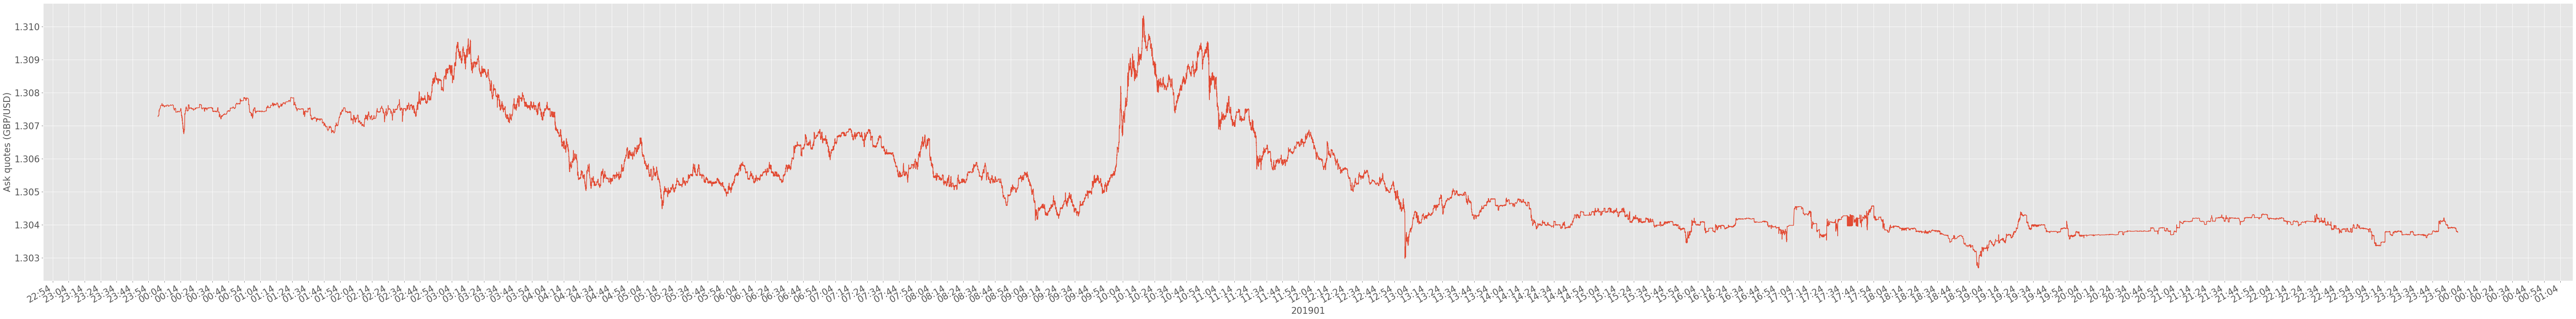

In [201]:
fig = plt.figure(num=None, figsize=(80, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(1, 1, 1)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('201901', fontsize=20)
plt.ylabel('Ask quotes (GBP/USD)', fontsize=20)

x = fx_190102.time
y = fx_190102.ask_quote
ax1.plot(x, y)


ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=10)) 
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
fig.autofmt_xdate()
fig.tight_layout()
plt.show()
plt.close() 
del x, y

In [ ]:
for i in range(news_190131.shape[0]):
    if news_190131['article_sentiment_p0.5'][i] == 1:
        ax2.axvline(news_190131.date[i])

In [ ]:
news_dict['201901'][news_dict['201901'].date.dt.day == 1].head()

In [ ]:
# for k in range(news_dict['201901'].shape[0]):
#             if news_dict['201901']['article_sentiment_p0.5'][k]:
#                 plt.axvline(news_dict['201901']['date'][k], color='r', linestyle='-', lw=1)
#                 plt.show()
#                 plt.close()

fig = plt.figure(num=None, figsize=(100, 10), dpi=100)
plt.style.use('ggplot')
ax1 = fig.subplots()
ax1.plot(fx_dict['201902'][fx_dict['201902'].time.dt.day == 1].time, 
            fx_dict['201902'][fx_dict['201902'].time.dt.day == 1].ask_quote, 
            color='r')
for k in range(news_dict['201902'][news_dict['201902'].date.dt.day == 1].shape[0]):
    if news_dict['201902'][news_dict['201902'].date.dt.day == 1].reset_index()['article_sentiment_p0.5'][k]:
        ax1.axvline(news_dict['201902'][news_dict['201902'].date.dt.day == 1].reset_index().date[k], color='r', linestyle='-', lw=1)

plt.show()
plt.close()

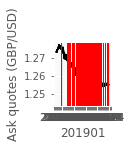

RuntimeError: Locator attempting to generate 77088 ticks from 736289.7555555556 to 737895.7347222222: exceeds Locator.MAXTICKS

In [180]:
for i in range(1, 16):
    axs = plt.subplot(3, 5, i)
    fig = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
    if i < 10:


        # Plot fx
        x = fx_dict['20190{}'.format(i)][fx_dict['20190{}'.format(i)].time.dt.day == 2].time
        y = fx_dict['20190{}'.format(i)][fx_dict['20190{}'.format(i)].time.dt.day == 2].ask_quote
        axs.plot(x, y, color='black')

        # Setting the panel

        axs.set_xlabel('20190{}'.format(i))
        axs.set_ylabel('Ask quotes (GBP/USD)') 


        # Plot news sentiments
        news_d = news_dict['20190{}'.format(i)][news_dict['20190{}'.format(i)].date.dt.day == 2].reset_index()
        for k in range(news_d.shape[0]):
            if news_d['article_sentiment_p0.5'][k]:
                axs.axvline(news_d.date[k], color='r', linestyle='-', lw=1)
        axs.xaxis.set_major_locator(mdates.MinuteLocator(interval=30)) 
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
        fig.autofmt_xdate()
        fig.tight_layout()


    elif i < 13:

        # Plot fx
        x = fx_dict['2019{}'.format(i)][fx_dict['2019{}'.format(i)].time.dt.day == 2].time
        y = fx_dict['2019{}'.format(i)][fx_dict['2019{}'.format(i)].time.dt.day == 2].ask_quote


        axs.plot(x, y, color='black')

        # Setting the panel

        axs.set_xlabel('20190{}'.format(i))
        axs.set_ylabel('Ask quotes (GBP/USD)') 

        # Plot news sentiments
        news_d = news_dict['2019{}'.format(i)][news_dict['2019{}'.format(i)].date.dt.day == 2].reset_index()
        for k in range(news_d.shape[0]):
            if news_d['article_sentiment_p0.5'][k]:
                axs.axvline(news_d.date[k], color='r', linestyle='-', lw=1)
        axs.xaxis.set_major_locator(mdates.MinuteLocator(interval=30)) 
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
        fig.autofmt_xdate()
        fig.tight_layout()

    else:

        # Plot fx
        x = fx_dict['20200{}'.format(i-12)][fx_dict['20200{}'.format(i-12)].time.dt.day == 2].time
        y = fx_dict['20200{}'.format(i-12)][fx_dict['20200{}'.format(i-12)].time.dt.day == 2].ask_quote

        axs.plot(x, y, color='black')
        
        # Setting the panel

        axs.set_xlabel('20190{}'.format(i-12))
        axs.set_ylabel('Ask quotes (GBP/USD)') 

        # Plot news sentiments
        news_d = news_dict['20200{}'.format(i-12)][news_dict['20200{}'.format(i-12)].date.dt.day == 2].reset_index()
        for k in range(news_d.shape[0]):
            if news_d['article_sentiment_p0.5'][k]:
                axs.axvline(news_d.date[k], color='r', linestyle='-', lw=1)
        axs.xaxis.set_major_locator(mdates.MinuteLocator(interval=30)) 
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
        fig.autofmt_xdate()
        fig.tight_layout()
plt.show()
plt.close() 


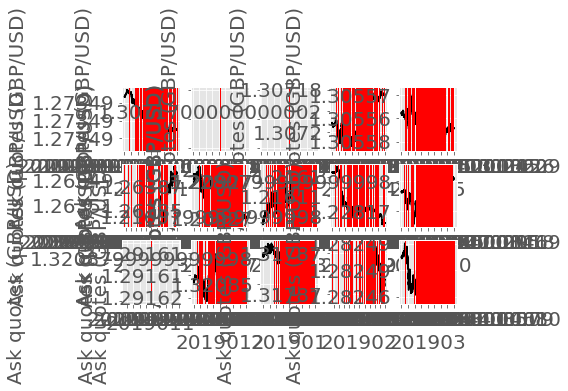

In [175]:
# for i in range(1, 16):
#     axs = plt.subplot(3, 5, i)

#     if i < 10:


#         # Plot fx
#         x = fx_dict['20190{}'.format(i)][fx_dict['20190{}'.format(i)].time.dt.day == 2].time
#         y = fx_dict['20190{}'.format(i)][fx_dict['20190{}'.format(i)].time.dt.day == 2].ask_quote
#         axs.plot(x, y, color='black')

#         # Setting the panel
#         axs.set_xticklabels(x, fontsize=20)
#         axs.set_yticklabels(y, fontsize=20)
#         axs.set_xlabel('20190{}'.format(i), fontsize=20)
#         axs.set_ylabel('Ask quotes (GBP/USD)', fontsize=20) 


#         # Plot news sentiments
#         news_d = news_dict['20190{}'.format(i)][news_dict['20190{}'.format(i)].date.dt.day == 2].reset_index()
#         for k in range(news_d.shape[0]):
#             if news_d['article_sentiment_p0.5'][k]:
#                 axs.axvline(news_d.date[k], color='r', linestyle='-', lw=1)

#         fig.autofmt_xdate()
#         fig.tight_layout()


#     elif i < 13:

#         # Plot fx
#         x = fx_dict['2019{}'.format(i)][fx_dict['2019{}'.format(i)].time.dt.day == 2].time
#         y = fx_dict['2019{}'.format(i)][fx_dict['2019{}'.format(i)].time.dt.day == 2].ask_quote


#         axs.plot(x, y, color='black')

#         # Setting the panel
#         axs.set_xticklabels(x, fontsize=20)
#         axs.set_yticklabels(y, fontsize=20)
#         axs.set_xlabel('20190{}'.format(i), fontsize=20)
#         axs.set_ylabel('Ask quotes (GBP/USD)', fontsize=20) 

#         # Plot news sentiments
#         news_d = news_dict['2019{}'.format(i)][news_dict['2019{}'.format(i)].date.dt.day == 2].reset_index()
#         for k in range(news_d.shape[0]):
#             if news_d['article_sentiment_p0.5'][k]:
#                 axs.axvline(news_d.date[k], color='r', linestyle='-', lw=1)

#         fig.autofmt_xdate()
#         fig.tight_layout()

#     else:

#         # Plot fx
#         x = fx_dict['20200{}'.format(i-12)][fx_dict['20200{}'.format(i-12)].time.dt.day == 2].time
#         y = fx_dict['20200{}'.format(i-12)][fx_dict['20200{}'.format(i-12)].time.dt.day == 2].ask_quote

#         axs.plot(x, y, color='black')
        
#         # Setting the panel
#         axs.set_xticklabels(x, fontsize=20)
#         axs.set_yticklabels(y, fontsize=20)
#         axs.set_xlabel('20190{}'.format(i-12), fontsize=20)
#         axs.set_ylabel('Ask quotes (GBP/USD)', fontsize=20) 

#         # Plot news sentiments
#         news_d = news_dict['20200{}'.format(i-12)][news_dict['20200{}'.format(i-12)].date.dt.day == 2].reset_index()
#         for k in range(news_d.shape[0]):
#             if news_d['article_sentiment_p0.5'][k]:
#                 axs.axvline(news_d.date[k], color='r', linestyle='-', lw=1)

#         fig.autofmt_xdate()
#         fig.tight_layout()
# plt.show()
# plt.close() 


In [ ]:
# for i in range(1, 16):
#     if i < 10:
#         # Setting the panel
#         fig = plt.figure(num=None, figsize=(100, 10), dpi=100)
#         plt.style.use('ggplot')
#         ax1 = fig.subplots()
#         color = 'tab:red'
#         ax1.set_xlabel('20190{}'.format(i), fontsize=40)
#         ax1.set_ylabel('GBP/USD ask quote', color=color, fontsize=40)
#         ax1.tick_params(axis='y', labelcolor=color, labelsize=40)
#         ax1.tick_params(axis='x', labelsize=40)

#         # Plotting
#         ax1.plot(fx_dict['20190{}'.format(i)][fx_dict['20190{}'.format(i)].time.dt.day == 2].time, 
#                  fx_dict['20190{}'.format(i)][fx_dict['20190{}'.format(i)].time.dt.day == 2].ask_quote, 
#                  color=color)
#         for k in range(news_dict['20190{}'.format(i)].shape[0]):
#             if news_dict['20190{}'.format(i)]['article_sentiment_p0.5'][k]:
#                 ax1.axvline(news_dict['20190{}'.format(i)][k], color='r', linestyle='-', lw=1)

#         # Setting the panel
#         ax2 = ax1.twinx() 
#         color = 'tab:blue'
#         ax2.set_ylabel('Sentiment score', color=color, fontsize=40)
#         ax2.tick_params(axis='y', labelcolor=color, labelsize=40)

#         fig.tight_layout()

#     elif i < 13:
#         fig = plt.figure(num=None, figsize=(100, 10), dpi=100)
#         plt.style.use('ggplot')
#         ax1 = fig.subplots()
#         color = 'tab:red'
#         ax1.set_xlabel('Time', fontsize=40)
#         ax1.set_ylabel('GBP/USD ask quote', color=color, fontsize=40)
#         ax1.plot(fx_dict['2019{}'.format(i)][fx_dict['2019{}'.format(i)].time.dt.day == 1].time, 
#                  fx_dict['2019{}'.format(i)][fx_dict['2019{}'.format(i)].time.dt.day == 1].ask_quote, 
#                  color=color)
#         ax1.tick_params(axis='y', labelcolor=color, labelsize=40)
#         ax1.tick_params(axis='x', labelsize=40)

#         ax2 = ax1.twinx() 
#         color = 'tab:blue'
#         ax2.set_ylabel('Sentiment score', color=color, fontsize=40)
#         ax2.tick_params(axis='y', labelcolor=color, labelsize=40)

#         fig.tight_layout()

#     else:
#         fig = plt.figure(num=None, figsize=(100, 10), dpi=100)
#         plt.style.use('ggplot')
#         ax1 = fig.subplots()
#         color = 'tab:red'
#         ax1.set_xlabel('Time', fontsize=40)
#         ax1.set_ylabel('GBP/USD ask quote', color=color, fontsize=40)
#         ax1.plot(fx_dict['20200{}'.format(i-12)][fx_dict['20200{}'.format(i-12)].time.dt.day == 1].time, 
#                  fx_dict['20200{}'.format(i-12)][fx_dict['20200{}'.format(i-12)].time.dt.day == 1].ask_quote, 
#                  color=color)
#         ax1.tick_params(axis='y', labelcolor=color, labelsize=40)
#         ax1.tick_params(axis='x', labelsize=40)

#         ax2 = ax1.twinx() 
#         color = 'tab:blue'
#         ax2.set_ylabel('Sentiment score', color=color, fontsize=40)
#         ax2.tick_params(axis='y', labelcolor=color, labelsize=40)

#         fig.tight_layout()


In [ ]:
# backup
      
news_190601 = news_dict['20190{}'.format(6)][news_dict['20190{}'.format(6)].date.dt.day == 1]
fx_190131 = fx_dict['20190{}'.format(i)][fx_dict['20190{}'.format(i)].time.dt.day == 31]

fig = plt.figure(num=None, figsize=(100, 10), dpi=100)
plt.style.use('ggplot')
ax1 = fig.subplots()
color = 'tab:red'
ax1.set_xlabel('Time', fontsize=40)
ax1.set_ylabel('GBP/USD ask quote', color=color, fontsize=40)
ax1.plot(fx_190131.time, fx_190131.ask_quote, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=40)
ax1.tick_params(axis='x', labelsize=40)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Sentiment score', color=color, fontsize=40)
ax2.scatter(news_190131.date, news_190131['article_sentiment_p0.5'], color=color, s=10, alpha=0)
ax2.tick_params(axis='y', labelcolor=color, labelsize=40)

fig.tight_layout()
fig.show()

fig.savefig('190131.png')

In [ ]:
fx_190601 = fx_dict['20190{}'.format(6)][fx_dict['20190{}'.format(6)].time.dt.day == 1]

In [ ]:
display_all(fx_190131.head(100))

In [ ]:
fig.xticks(fontsize=14, rotation=90)
fig.yticks(fontsize=14)


In [ ]:
news_190131.reset_index(inplace=True)

In [ ]:
news_190131.to_csv('news_190131.csv')

In [ ]:
fx_190131.to_csv('fx_190131.csv')

In [ ]:
news_190131.date[2]

In [ ]:
News.shape